In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy import spatial # for cosine similarity - https://stackoverflow.com/a/18424933
#import tikzplotlib
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import os
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#^ GAF
from pyts.image import GramianAngularField

#^ OUR functions
sys.path.append('/home/pablo/xai-tool-timeseries-server_lab/xai-tool-timeseries/methods/')
from utils import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models import LSTM, DLinear, PatchTST,Linear,TSMixer,PatchTST_c,Linear_c,TSMixer_c
import argparse
import torchvision.transforms as transforms
from torchvision.models import resnet50,resnet18
import time
import shap
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#import seaborn as sns

In [2]:
dataset='eumaclf' #users or euma
users_bs=2
univariate='True' #False if multivariate 
model_names=['patchtst','linear','tsmixer','multirocket'] #'dlinear','patchtst', 'lstm'
lookback,horizon=24,23 #Use the same values as in run.py
exp_dict={}
X_train,X_test,y_train,y_test=dataset_dict[dataset](lookback,horizon,dataset=dataset,frequency=users_bs,univariate=univariate)
y=y_test.squeeze().numpy()

if dataset=='users':
        dataset=f'users_bs{users_bs}'
for model_name in model_names:
        if univariate=='False':
                model_fname=model_name+'_mv'
        else:
               model_fname=model_name 
        with open(f'./results/configs/{model_fname}_{dataset}_{lookback}_{horizon}_configs.pkl', 'rb') as f:
                configs=pickle.load(f)
        X_test_rs=X_test.reshape(X_test.shape[0],configs.enc_in*configs.seq_len)
        X_train_rs=X_train.reshape(X_train.shape[0],configs.enc_in*configs.seq_len)
        y_test_rs=y_test.reshape(X_test.shape[0],configs.enc_in)
        X_test_exp=X_test_rs.unsqueeze(dim=-1).expand(-1,-1,configs.pred_len*configs.enc_in)
        temp_dict={}
        temp_dict['model']=model_dict[model_name](configs)
        temp_dict['model'].load_state_dict(torch.load(f'results/trained_models/{model_fname}_{dataset}_{lookback}_{horizon}.pt'))
        #temp_dict['pred_train']=temp_dict['model'](X_train).squeeze().detach()
        temp_dict['pred_test_rs']=torch.tensor(np.loadtxt(f'./results/predictions/{model_fname}_{dataset}_{lookback}_{horizon}_predictions.txt'))
        temp_dict['pred_test']=temp_dict['pred_test_rs'].reshape(-1,configs.pred_len,configs.enc_in)
        #temp_dict['error_train']=y_train.detach()-temp_dict['pred_train']
        temp_dict['error_test']=y_test.detach()-temp_dict['pred_test']
        temp_dict['error_test_rs']=y_test_rs.detach()-temp_dict['pred_test_rs']
        
        with open(f'./results/shap_values/shap_values_test_{dataset}_{model_fname}_{lookback}_{horizon}.pkl', 'rb') as f:
                temp_dict['shap_values_test_rs']=pickle.load(f).values
        temp_dict['shap_values_test']=temp_dict['shap_values_test_rs'].reshape(X_test.shape[0],-1,configs.pred_len,configs.enc_in)
        #with open(f'./results/shap_values/shap_values_train_{dataset}_{model_name}_{lookback}_{horizon}.pkl', 'rb') as f:
               # temp_dict['shap_values_train_rs']=pickle.load(f).values
        #temp_dict['shap_values_train']=temp_dict['shap_values_train_rs'].reshape(X_train.shape[0],-1,configs.pred_len,configs.enc_in)
        temp_dict['w_matrix'],temp_dict['xai_matrix']=linear_xai(X_test_rs,temp_dict['shap_values_test_rs'])
        #temp_dict['w_matrix_train'],temp_dict['xai_matrix_train']=linear_xai(X_train_rs,temp_dict['shap_values_train_rs'])
        temp_dict['pred_w_rs']=torch.matmul(temp_dict['w_matrix'].permute(0,2,1).float(),X_test_exp)[:,:,0]
        temp_dict['pred_w']=temp_dict['pred_w_rs'].reshape(X_test.shape[0],configs.pred_len,configs.enc_in)
        temp_dict['bias_rs']=temp_dict['pred_w_rs'][0]-temp_dict['pred_test_rs'][0].detach()
        temp_dict['bias']=temp_dict['bias_rs'].reshape(configs.pred_len,configs.enc_in)
        temp_dict['wv_matrix']=temp_dict['xai_matrix']*X_test_exp
        temp_dict['pred_test_labels']=temp_dict['pred_test'].max(dim=1).indices.squeeze()
        #temp_dict['pred_train_labels']=temp_dict['pred_train'].max(dim=1).indices.squeeze()
        temp_dict['clf_err']=temp_dict['pred_test_labels']-y_test
        temp_dict['confusion_matrix']=confusion_matrix(y_test, temp_dict['pred_test_labels'])
        exp_dict[model_name]=temp_dict
if dataset=='eumaclf':
        label_names=['Apple Music', 'Apple Video', 'Apple iCloud', 'Apple iTunes',
       'DailyMotion', 'Deezer', 'Facebook', 'Facebook Live',
       'Google Drive', 'Google Maps', 'Google Meet', 'Google Play Store',
       'Instagram', 'LinkedIn', 'Microsoft Store', 'Netflix', 'Pinterest',
       'SnapChat', 'Spotify', 'Twitch', 'Twitter', 'WhatsApp', 'Youtube']
        

/opt/miniconda3/envs/chronolens/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
print('accuracy scores:')
for model_name in model_names:
    print(model_name+':',round(accuracy_score(y_test,exp_dict[model_name]['pred_test_labels']),2))

accuracy scores:
patchtst: 0.87
linear: 0.6
tsmixer: 0.81
multirocket: 0.92


In [88]:
model_name='tsmixer'
print(model_name)
print(exp_dict[model_name]['confusion_matrix'])

tsmixer
[[82 43]
 [65 60]]


## Visualization

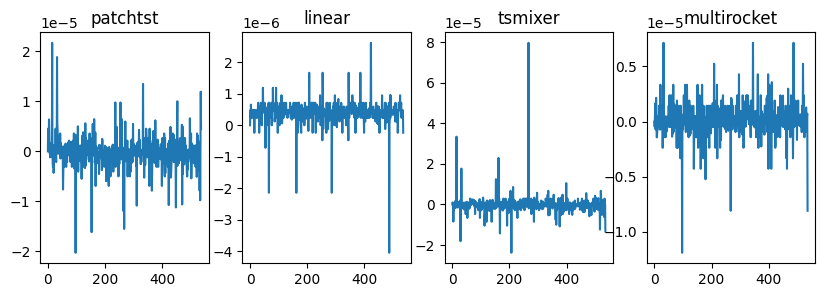

In [77]:
#how close are the meta predictions with respect to the original ones while using the virutal weights
h=0
v=0
samples=-1
fig,ax=plt.subplots(1,len(exp_dict.keys()),figsize=(10,3))
for i,model_name in enumerate(exp_dict.keys()):
    num_error=exp_dict[model_name]['pred_test'][:samples,h,v].detach().squeeze()-exp_dict[model_name]['pred_w'][:samples,h,v].squeeze()+exp_dict[model_name]['bias'][h,v]
    ax[i].plot(num_error)
    ax[i].set_title(model_name)

In [ ]:
#classes
for n,i in enumerate(label_names):
    print(n,i)

0 Apple Music
1 Apple Video
2 Apple iCloud
3 Apple iTunes
4 DailyMotion
5 Deezer
6 Facebook
7 Facebook Live
8 Google Drive
9 Google Maps
10 Google Meet
11 Google Play Store
12 Instagram
13 LinkedIn
14 Microsoft Store
15 Netflix
16 Pinterest
17 SnapChat
18 Spotify
19 Twitch
20 Twitter
21 WhatsApp
22 Youtube


In [ ]:
#models
exp_dict.keys()

dict_keys(['patchtst', 'linear', 'tsmixer', 'multirocket'])

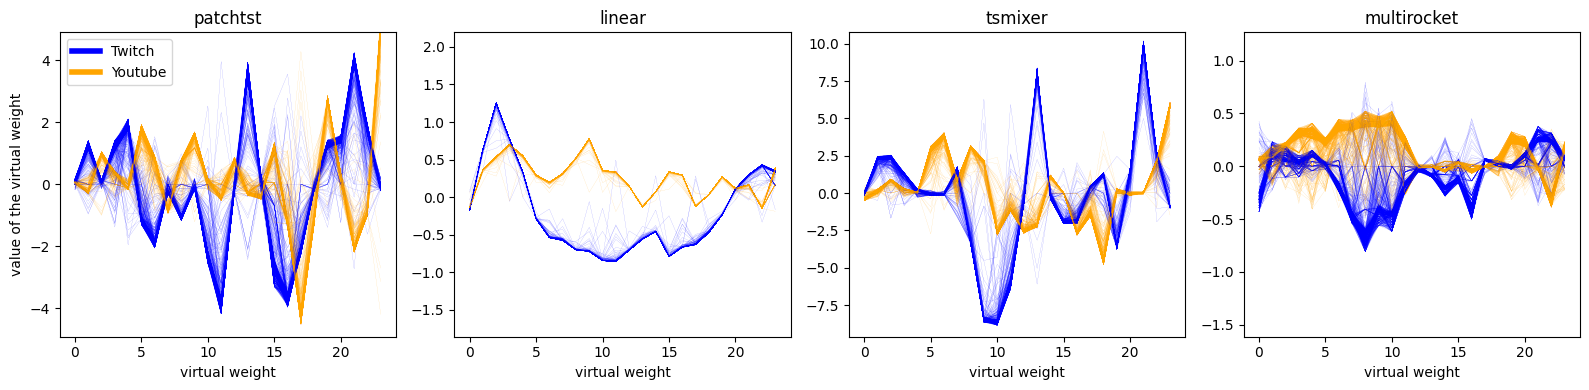

In [17]:

# Define the classes
classes = [19,22]

# Create the figure and axes
fig, ax = plt.subplots(1, len(exp_dict.keys()), figsize=(16, 4))

# Define the colors for the classes
class_colors = ['b', 'orange']

for t, model_name in enumerate(exp_dict.keys()):
    w_fil = clean_outliers(exp_dict[model_name]['w_matrix'],.99)
    for i in range(len(exp_dict[model_name]['w_matrix'])):
        ax[t].set_title(model_name)
        quantile1 = exp_dict[model_name]['w_matrix'][i, :, classes[0]].quantile(0.001)
        quantile2 = exp_dict[model_name]['w_matrix'][i, :, classes[0]].quantile(0.995)
        
        # Plot the data with labels only for the first line of each class to avoid duplicates in the legend
        if i == 0:
            ax[t].plot(w_fil[i, :, classes[0]], class_colors[0], alpha=0.6, linewidth=0.1, label=f'Class {classes[0]}')
            ax[t].plot(w_fil[i, :, classes[1]], class_colors[1], alpha=0.6, linewidth=0.1, label=f'Class {classes[1]}')
        else:
            ax[t].plot(w_fil[i, :, classes[0]], class_colors[0], alpha=0.6, linewidth=0.1)
            ax[t].plot(w_fil[i, :, classes[1]], class_colors[1], alpha=0.6, linewidth=0.1)
        
        ax[t].set_ylim(quantile1 - 1, quantile2 + 1)
    
    ax[t].set_xlabel('virtual weight')

ax[0].set_ylabel('value of the virtual weight')

# Create custom legend handles with full opacity
legend_handles = [Line2D([0], [0], color=class_colors[0], lw=4, label=label_names[classes[0]]),
                  Line2D([0], [0], color=class_colors[1], lw=4, label=label_names[classes[1]])]

# Add legend to the first subplot only
ax[0].legend(handles=legend_handles)

plt.tight_layout()
tikzplotlib.save('weights_clf.tex')

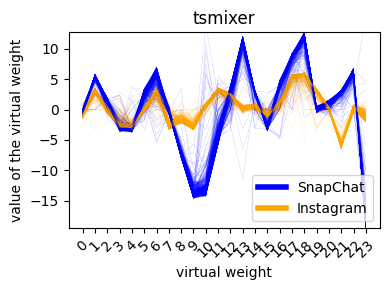

In [11]:
# Define the classes
classes = [17,12]

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Define the colors for the classes
class_colors = ['b', 'orange']
model_name='tsmixer'
w_fil = clean_outliers(exp_dict[model_name]['w_matrix'],.99)
for i in range(len(exp_dict[model_name]['w_matrix'])):
    ax.set_title(model_name)
    quantile1 = exp_dict[model_name]['w_matrix'][i, :, classes[0]].quantile(0.001)
    quantile2 = exp_dict[model_name]['w_matrix'][i, :, classes[0]].quantile(0.995)
    
    # Plot the data with labels only for the first line of each class to avoid duplicates in the legend
    if i == 0:
        ax.plot(w_fil[i, :, classes[0]], class_colors[0], alpha=0.6, linewidth=0.1, label=f'Class {classes[0]}')
        ax.plot(w_fil[i, :, classes[1]], class_colors[1], alpha=0.6, linewidth=0.1, label=f'Class {classes[1]}')
    else:
        ax.plot(w_fil[i, :, classes[0]], class_colors[0], alpha=0.6, linewidth=0.1)
        ax.plot(w_fil[i, :, classes[1]], class_colors[1], alpha=0.6, linewidth=0.1)
    
    ax.set_ylim(quantile1 - 1, quantile2 + 1)

ax.set_xlabel('virtual weight')

ax.set_ylabel('value of the virtual weight')

# Create custom legend handles with full opacity
legend_handles = [Line2D([0], [0], color=class_colors[0], lw=4, label=label_names[classes[0]]),
                Line2D([0], [0], color=class_colors[1], lw=4, label=label_names[classes[1]])]

# Add legend to the first subplot only
ax.legend(handles=legend_handles)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24),rotation=45)
plt.tight_layout()
#tikzplotlib.save('snapchat-instagram-arp.tex')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

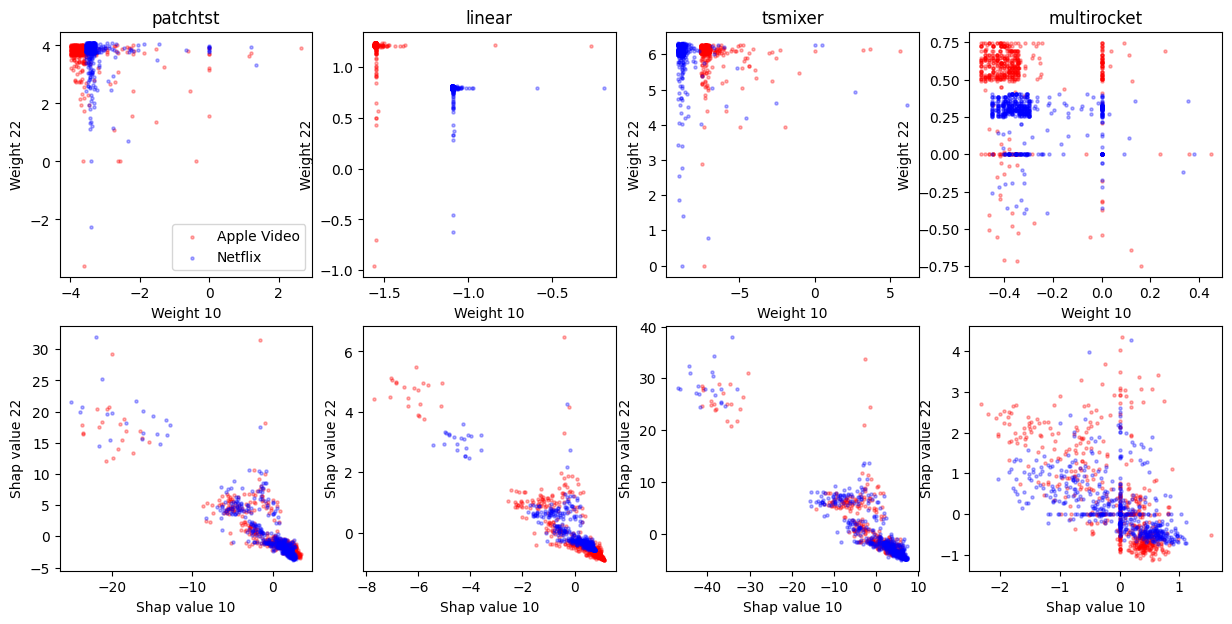

In [67]:
# Define the classes and weights

classes = [1,15]
weights = [10,22]
# Predefined list of colors (e.g., using some distinct colors)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
fig, ax = plt.subplots(2,len(exp_dict.keys()),figsize=(15,7))
for c, cc in enumerate(classes):
    for t,model_name in enumerate(exp_dict.keys()):
        ax[0,t].set_title(model_name)
        color = colors[c % len(colors)]  # Cycle through colors if there are more classes than colors
        x = clean_outliers(exp_dict[model_name]['w_matrix'])[:, weights[0], cc]
        y = clean_outliers(exp_dict[model_name]['w_matrix'])[:, weights[1], cc]
        ax[0,t].scatter(x, y, c=color, label=label_names[cc],s=5,alpha=.3)
        ax[0,t].set_ylabel(f'Weight {weights[1]}')
        ax[0,t].set_xlabel(f'Weight {weights[0]}')
        x = exp_dict[model_name]['shap_values_test'][:, weights[0], cc]
        y = exp_dict[model_name]['shap_values_test'][:, weights[1], cc]
        ax[1,t].scatter(x, y, c=color, label=label_names[cc],s=5,alpha=.3)
        ax[1,t].set_ylabel(f'Shap value {weights[1]}')
        ax[1,t].set_xlabel(f'Shap value {weights[0]}')

ax[0,0].legend()
plt.tight_layout
#plt.show()
#tikzplotlib.save('10_3_weights_shap_clf.tex')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


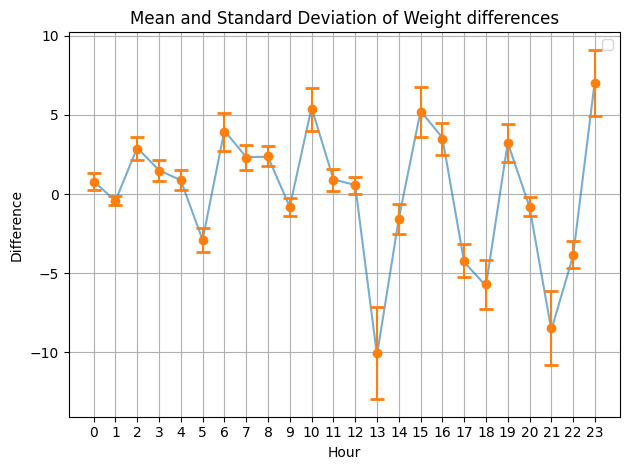

In [32]:
model_name='patchtst'
classes = [0,18]
plt.plot(range(24),w_diff(classes,clean_outliers(exp_dict[model_name]['w_matrix'])).mean(dim=0),alpha=.6)
plt.errorbar(range(24),w_diff(classes,clean_outliers(exp_dict[model_name]['w_matrix'])).mean(dim=0), yerr=clean_outliers(w_diff(classes,exp_dict['patchtst']['w_matrix'])).std(dim=0), fmt='o', capsize=5, capthick=2)
plt.xticks(range(24))  # set the x-axis labels to the variable indices
plt.xlabel('Hour')
plt.ylabel('Difference')
plt.title('Mean and Standard Deviation of Weight differences')
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid()
plt.show()

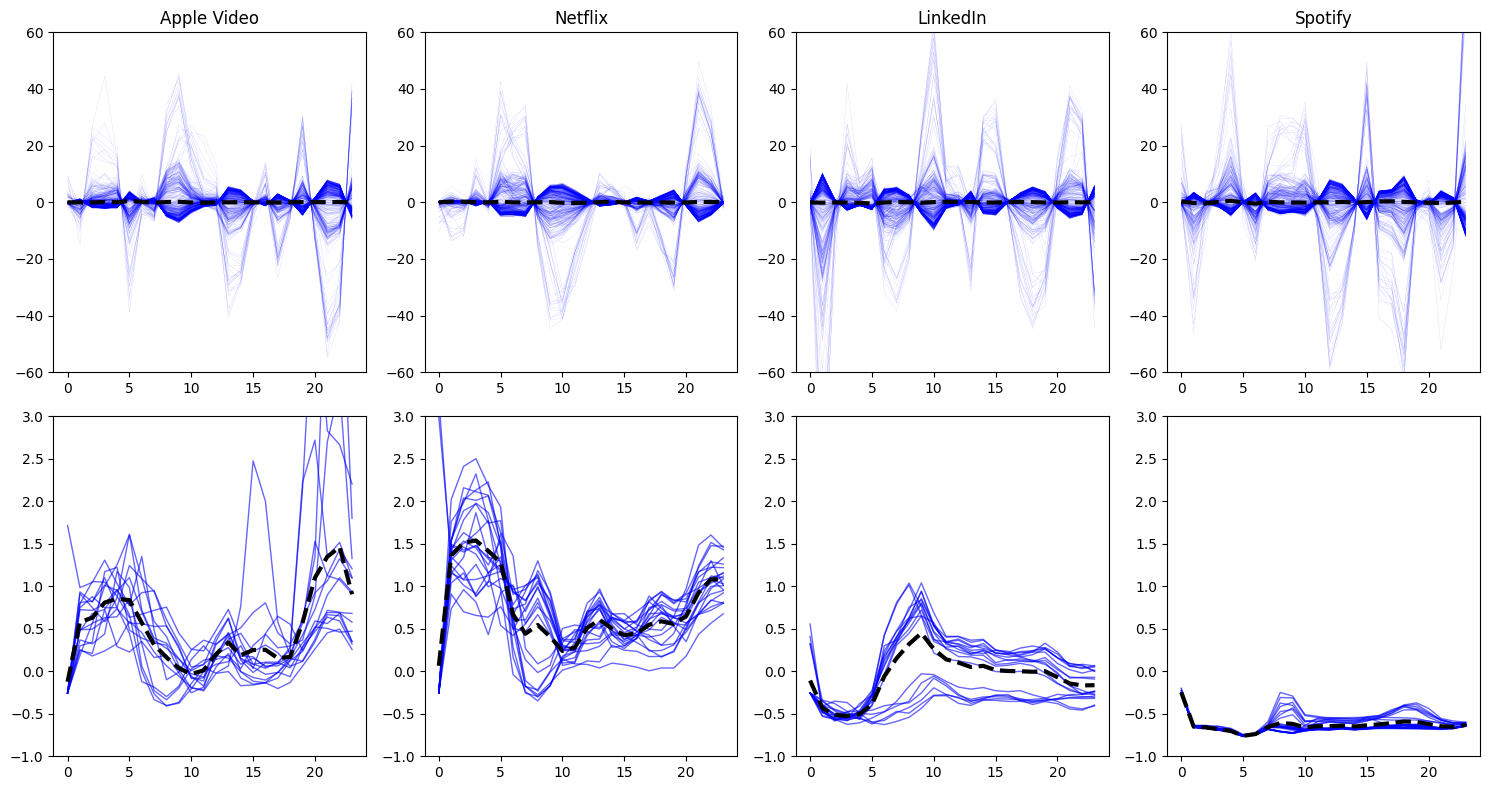

In [105]:
apps = ['Apple Video','Netflix','LinkedIn','Spotify']

fig, axs = plt.subplots(2, len(apps), figsize=(15, 8))

# Flatten the 2D array of axes to easily iterate over it
axs = axs.flatten()

# Loop through each subplot and add some example data
for i,app in enumerate(apps):


    
    index = apps_dict[app]
    indices_class = np.where(y_test == index)[0]


    axs[i].plot(exp_dict['tsmixer']['shap_values_test'].squeeze(-1)[:,:,i].T,color = 'blue', linewidth=0.1,alpha=0.4,label='shap values') 
    axs[i].plot(exp_dict['tsmixer']['shap_values_test'].squeeze(-1)[:,:,index].mean(axis = 0),  'k--', linewidth = 3,label='mean')  
    axs[i+len(apps)].plot(X_test[indices_class].squeeze(-1).T, color = 'blue', linewidth = 1,alpha=.6,label='sequence')
    axs[i+len(apps)].plot(X_test[indices_class].squeeze(-1).T.mean(dim=1), 'k--', linewidth = 3,label='mean')
    axs[i+len(apps)].set_ylim(-1,3)
    axs[i].set_title(app)
    axs[i].set_ylim(-60,60)



# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
tikzplotlib.save('motivation.tex')


In [6]:
for n,i in enumerate(label_names):
    print(n,i)

0 Apple Music
1 Apple Video
2 Apple iCloud
3 Apple iTunes
4 DailyMotion
5 Deezer
6 Facebook
7 Facebook Live
8 Google Drive
9 Google Maps
10 Google Meet
11 Google Play Store
12 Instagram
13 LinkedIn
14 Microsoft Store
15 Netflix
16 Pinterest
17 SnapChat
18 Spotify
19 Twitch
20 Twitter
21 WhatsApp
22 Youtube


In [4]:
model_name='patchtst'
err_index=np.where(exp_dict[model_name]['pred_test_labels']!=y_test)[0]
print(err_index)

[  1  13  16  18  25  27  28  42  55  56  59  74  84  87 110 129 130 140
 145 158 159 174 175 180 186 199 209 217 225 240 243 256 267 274 278 283
 290 293 299 309 313 316 331 337 346 350 361 362 370 372 373 384 397 402
 406 428 435 449 460 471 480 497 500 501 514 518 519 522 527]


460 pathtst

In [15]:
n=501
print(exp_dict[model_name]['pred_test_labels'][n].item(),y_test[n].item())
print(exp_dict[model_name]['pred_test'][n][exp_dict[model_name]['pred_test_labels'][n].item()],exp_dict[model_name]['pred_test'][n,y_test[n].item()])

0 18
tensor([12.1521], dtype=torch.float64) tensor([3.0041], dtype=torch.float64)


patchtst 501 [0, 18] Apple Music Spotify


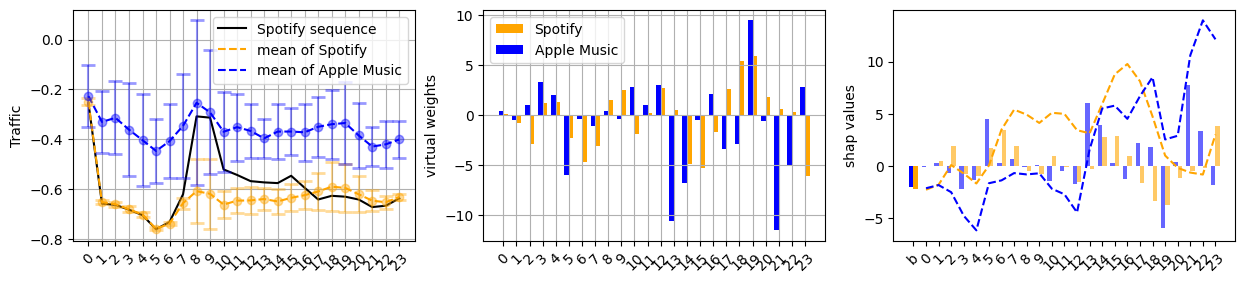

In [12]:
c=[exp_dict[model_name]['pred_test_labels'][n].item(),y_test[n].item()]
print(model_name,n,c,label_names[c[0]],label_names[c[1]])
#---------
r=range(24)
x = np.arange(24)
width=.35
X=X_test[:,:,0]
#---------
fig,ax=plt.subplots(1,3,figsize=(15,3))
ax[0].plot(X[n],'k',label=f'{label_names[c[1]]} sequence')
#class 1
ax[0].plot(X[y_test==c[1]].mean(dim=0),'--',color='orange',label=f'mean of {label_names[c[1]]}')
ax[0].errorbar(r,X[y_test==c[1]].mean(dim=0), yerr=X_test[:,:,0][y_test==c[1]].std(dim=0), fmt='o',color='orange', capsize=5, capthick=2,alpha=.4)
ax[1].bar(x + width/2, exp_dict[model_name]['w_matrix'][n, :, c[1]], width, label=label_names[c[1]], color='orange')
ax[2].bar(x + width/2, exp_dict[model_name]['shap_values_test'][n, :, c[1]].squeeze(), width, color='orange', alpha=0.6, label=label_names[c[1]])
ax[2].plot(np.cumsum(exp_dict[model_name]['shap_values_test'][n,:,c[1]])-exp_dict[model_name]['bias'][c[1],0].item(),'--',color='orange')
#class 0
ax[0].plot(X[y_test==c[0]].mean(dim=0),'b--',label=f'mean of {label_names[c[0]]}')
ax[0].errorbar(r,X[y_test==c[0]].mean(dim=0), yerr=X_test[:,:,0][y_test==c[0]].std(dim=0), fmt='bo', capsize=5, capthick=2,alpha=.4)
ax[1].bar(x - width/2, exp_dict[model_name]['w_matrix'][n, :, c[0]], width, label=label_names[c[0]], color='b')
ax[2].bar(x - width/2, exp_dict[model_name]['shap_values_test'][n, :, c[0]].squeeze(), width, color='b', alpha=0.6, label=label_names[c[0]])
ax[2].plot(np.cumsum(exp_dict[model_name]['shap_values_test'][n,:,c[0]])-exp_dict[model_name]['bias'][c[0],0].item(),'--b')

# Bias bars
ax[2].bar(-1 - width/2, -exp_dict[model_name]['bias'][c[0], 0].item(), width, color='b')
ax[2].bar(-1 + width/2, -exp_dict[model_name]['bias'][c[1], 0].item(), width, color='orange')
ax[0].set_ylabel('Traffic')
ax[1].set_ylabel('virtual weights')
ax[2].set_ylabel('shap values')
ticklab=['b']
ticklab.extend(list(range(24)))
for i in range(2):
    ax[i].set_xticks(range(24))
    ax[i].set_xticklabels(range(24),rotation=45)
    ax[i].legend()
ax[2].set_xticks(range(-1,24))
ax[2].set_xticklabels(ticklab,rotation=45)    
ax[1].grid()
ax[0].grid()